# Testing a Fake Dictionary Against its Training Dictionary
As the pseudo-words generated in this project are intended to be used in the context of psycholinguistic studies, we will now test a generated set to try to find out if there are aspects of the pseudo-words that may allow future test takers to spot  them based on statistical heuristics.  One interesting aspect about training the model on a full dictionary is that we get some fairly rare instances, and we can see, when generating an equally large set of words, how well was the training set "digested" by our model. For instance, our set of Breton lemmas only contains 31 items starting with the character "z" on out of a total of 62 172 items. That is 0.05% chances of having a word starting with a "z" or 1 chance for 2005 items. As we don't only want our model to learn the main traits of our lexis, but the entire diversity of what a "plausible" word in the language looks like, we want our model to be able to reproduce such outlier in similar proportions. One can only inspect this by producing an equally large set of pseudo-words as the original set of words (see chapter 2) before analyzing it in here.

In [1]:
import json

locale = "br"
lemmas_file_path = f"locales/{locale}/lemmas.json"
pseudo_lemmas_file_path =  f"locales/{locale}/pseudo-lemmas.json"

try:
    with open(lemmas_file_path) as f:
        content = f.read()
        if not content.strip():
            raise ValueError("The JSON file is empty.")
        lemmas = json.loads(content)
except FileNotFoundError:
    print(f"Error: File not found at {lemmas_file_path}")
    lemmas = []
except ValueError as e:
    print(f"Error: {e}")
    lemmas = []
except json.JSONDecodeError:
    print(f"Error: Invalid JSON content in {lemmas_file_path}")

try:
    with open(pseudo_lemmas_file_path) as f2:
        content2 = f2.read()
        if not content2.strip():
            raise ValueError("The JSON file is empty.")
        pseudo_lemmas = json.loads(content2)
except FileNotFoundError:
    print(f"Error: File not found at {pseudo_lemmas_file_path}")
    pseudo_lemmas = []
except ValueError as e:
    print(f"Error: {e}")
    pseudo_lemmas = []
except json.JSONDecodeError:
    print(f"Error: Invalid JSON content in {file_path}")

print(f"{len(lemmas)} items loaded from {lemmas_file_path}:\n" + "\n".join(lemmas[:10]))
print(f"{len(pseudo_lemmas)} items loaded from {pseudo_lemmas_file_path}:\n" + "\n".join(pseudo_lemmas[:10]))


62169 items loaded from locales/br/lemmas.json:
'gozik
'keda
'kre
're
'ta
'tav
'toue
a-abadennoù
a-adlamm
a-adwezh
62169 items loaded from locales/br/pseudo-lemmas.json:
'ac'haañ
'ejast
'harzhpetez
'hidion
'hirañsiñ
'hudenniñ
'huner
a-abid
a-abo
a-asvaoulañ


## 1. The length of the words
First, let's look at the average length difference between the two sets. As we can see below, the pseudo-words are in average a little longer than their real counterparts. Then we'll try to understand what part of the generated set differs from the original set by comparing the quantity of items for a given length.

In [4]:
lemmas_str = "".join(lemmas)
pseudo_lemmas_str = "".join(pseudo_lemmas)
print(len(lemmas_str)/len(lemmas))
print(len(pseudo_lemmas_str)/len(pseudo_lemmas))

8.250639386189258
8.480432369830623


    Lemmas Lengths  Pseudo-Lemmas Lengths
0                0                      0
1                0                      0
2              109                      6
3              745                    174
4             2003                    942
5             4365                   3200
6             8089                   7209
7             9843                  10380
8            10369                  11832
9             9340                  10350
10            6839                   7476
11            4634                   4908
12            2750                   2706
13            1411                   1445
14             808                    788
15             378                    369
16             202                    174
17             105                     95
18              69                     44
19              45                     28
20              25                     24
21              15                      9
22               9                

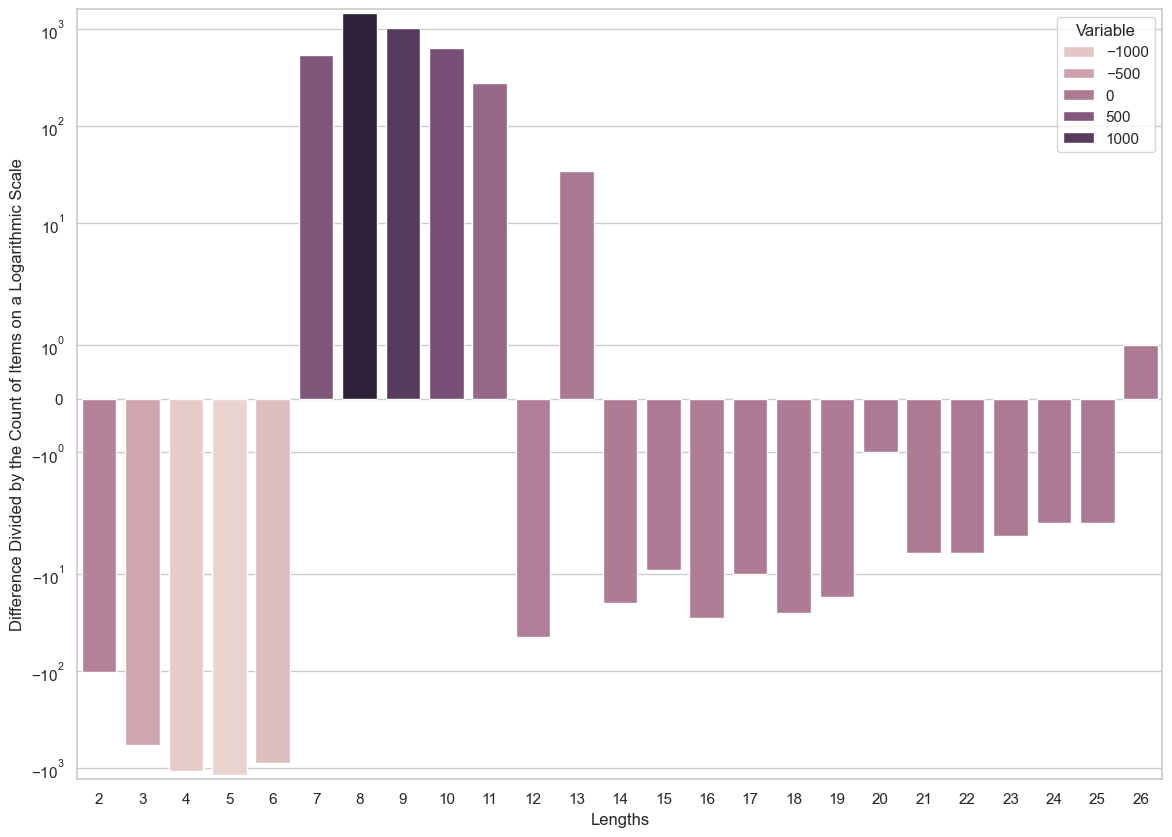

boc'hadenn-ar-bilh-basigeg


In [10]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

lemmas_counter = dict(Counter([len(l) for l in lemmas]))
pseudo_lemmas_counter = dict(Counter([len(l) for l in pseudo_lemmas]))
data = []
for i in range(max([i for i in lemmas_counter.keys()] + [i for i in pseudo_lemmas_counter.keys()]) + 1):
    data.append({
        "Lemmas Lengths": lemmas_counter[i] if i in lemmas_counter else 0,
        "Pseudo-Lemmas Lengths": pseudo_lemmas_counter[i] if i in pseudo_lemmas_counter else 0
    })


lengths_df = pd.DataFrame(data)
print(lengths_df)
lengths_df["Length Difference"] = (lengths_df["Pseudo-Lemmas Lengths"] - lengths_df["Lemmas Lengths"])

lengths_df.index.name = 'Lengths'
lengths_df = lengths_df.drop([0, 1])

plt.figure(figsize=(14, 10))
sns.set_style('whitegrid')


bar_plot = sns.barplot(
    x='Lengths',
    y="Length Difference",
    hue="Length Difference",
    data=lengths_df
)
plt.yscale('symlog')

# plt.title('Comparison of the Lengths of Types and Pseudo-Words', fontsize=16)
plt.xlabel('Lengths', fontsize=12)
plt.ylabel('Difference Divided by the Count of Items on a Logarithmic Scale', fontsize=12)
plt.legend(title='Variable')
plt.show()

print(max(pseudo_lemmas, key=len))

Here we see that the lengths of the generated words varies greatly from the training set. The explanation is straightforward, the scarcity of items with either few or large numbers of characters forbid the model to learn properly to create long or short words. One of the explication for the lack of short words may be due to the fact that a large part of the plausible short words are "already taken" and that the model initially generated the right amount of short words, but did not retain them in the final list because those words were real. But if the model did not learn well to reproduce the exact probabilities of short or long words, it still did what would be impossible for a gram-based HMCM. It can create two-characters-long words and even words (at least one in this set) longer than anything it has ever seen during training. This underscores once again the successful learning of patterns over pure distributions.

Next, we'll look at the characters' distribution.

## 2. General Characters Distribution
First, let's take a look at the distribution of characters regardless of their position in the words. Even a fairly accurate model, one which was trained with a low cross-entropy (below 1.8 is excellent) can produce words that look all "alike", think of the "most plausible words", if the temperature were too low. Otherwise, if the temperature is too high, the probabilities painfully learnt by the model during training would be offset by a too strong randomization. We start by loading the items.

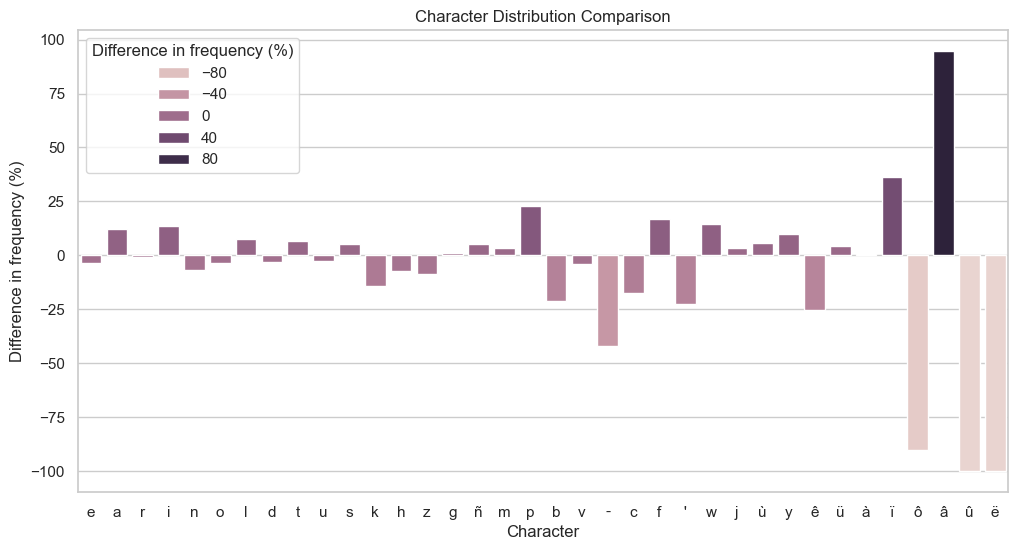

36

In [9]:
cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

chars = set(lemmas_str + pseudo_lemmas_str)
counter_lem = Counter(lemmas_str)
counter_psd = Counter(pseudo_lemmas_str)

data = []
for char in chars:
        freq_lemmas = (counter_lem.get(char, 0) / len(lemmas_str)) * 100 if lemmas_str else 0
        freq_pseudo_lemmas = (counter_psd.get(char, 0) / len(pseudo_lemmas_str)) * 100 if pseudo_lemmas_str else 0
        data.append({'Character': char, "lemmas": freq_lemmas, "pseudo_lemmas": freq_pseudo_lemmas})


df = pd.DataFrame(data)
df['avg'] = (df["lemmas"] + df["pseudo_lemmas"]) / 2
df['Difference in frequency (%)'] = (df["lemmas"] - df["pseudo_lemmas"]) * -100 / df["lemmas"]
df = df.sort_values('avg', ascending=False).drop('avg', axis=1)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Character', y='Difference in frequency (%)', hue='Difference in frequency (%)', data=df)
plt.title('Character Distribution Comparison')
plt.show()
len(chars)

As expected, there are a few variations, especially as the characters become rarer, the variations become more important. Some low frequency characters however display a higher frequency in the generated set. This may be explained by the fact that the characters in questions mostly appears within regular structures, like "'", which mostly appears between "c" and "h", in the trigram "c'h", a frequent letter in Breton, same thing for "à" which often occurs as a contraction to "war" ("àr" meaning on, upon) in the beginning of a word, think of English words like "onwards", "ongoing" etc... Conversely, the location of the hyphens seem to have confused the model to a point that it did not learn properly where to place it. Some characters were not generated at all, but their frequency in the training set is very low, 1 to 5 for the entire set. The higher frequency of some rare characters in the generated set indicates a propensity of the model to learn the structures rather than pure probabilities, which is encouraging.  

Finally, we'll look at the frequencies of the first characters.

## 3. Distribution of the First Characters
Psycholinguists teach us that the beginning of a word is fundamental in the recognition of a word, more so than the way they end. This is why we inspect their distributions here.

First characters are the same: True 28


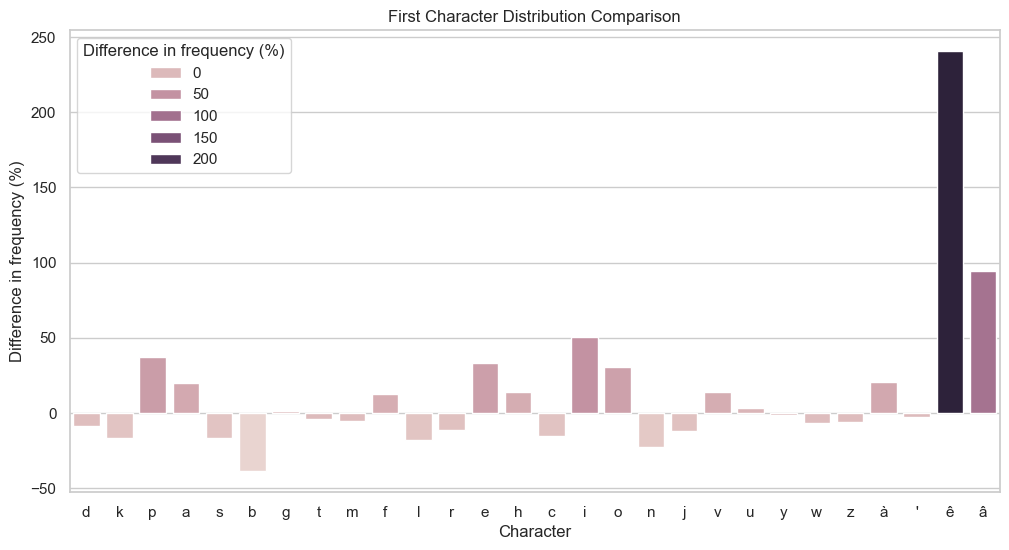

Average difference: 13.84%


In [10]:
cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

counter_lem = Counter("".join([i[0] for i in lemmas]))
counter_psd = Counter("".join([i[0] for i in pseudo_lemmas]))
chars = set("".join([i[0] for i in lemmas] + [i[0] for i in pseudo_lemmas]))
print("First characters are the same:", counter_psd.keys() == counter_lem.keys(), f"{len(chars)}")

data = []
for char in chars:
        freq_lemmas = (counter_lem.get(char, 0) / len(lemmas_str)) * 100 if lemmas_str else 0
        freq_pseudo_lemmas = (counter_psd.get(char, 0) / len(pseudo_lemmas_str)) * 100 if pseudo_lemmas_str else 0
        data.append({'Character': char, "lemmas": freq_lemmas, "pseudo_lemmas": freq_pseudo_lemmas})


df = pd.DataFrame(data)
df['avg'] = (df["lemmas"] + df["pseudo_lemmas"]) / 2
df['Difference in frequency (%)'] = (df["lemmas"] - df["pseudo_lemmas"]) * -100 / df["lemmas"]
df = df.sort_values('avg', ascending=False).drop('avg', axis=1)
average_difference = df["Difference in frequency (%)"].sum() / len(chars)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Character', y='Difference in frequency (%)', hue='Difference in frequency (%)', data=df)
plt.title('First Character Distribution Comparison')
plt.show()
print(f"Average difference: {average_difference:.2f}%")

As we can see, most items oscillate within a range of more or less 50% in regard to the original set, often less than 25% and an average of 13.84%. Only the two least common first letters are being over-represented, which together with the underrepresentation of the two most common first characters may indicate that a slightly too high temperature was used for this particular model. 
But the most important thing, that validates the quality of this model, is the fact that all 28  characters starting pseudo lemmas are the same as those found in the original dictionary. There are 36 characters identified in the previous graph, and if the model had generated a word starting with "ñ" or "-" it would have indicated a problem during the training.  

# Saving satisfying results
Only if the results are satisfying enough, one can package both the lemmas and the pseudo-words in a single file ready for exploitation.

In [5]:
file = {
    "version": 2,
    "keys": [{"w": l, "r": 200} for l in lemmas],
    "distractors": [{"w": l, "r": -200} for l in pseudo_lemmas],
}

# Define the output file path
output_file_path = f"locales/{locale}/items.json"

# Write the lemmas list to the JSON file
with open(output_file_path, 'w', encoding='utf-8') as outfile:
    json.dump(file, outfile, ensure_ascii=False, indent=4)
